#Imports

In [15]:
from google.colab import drive
import os
import shutil
import os, shutil, sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Preparar a árvore de pastas


1.   treino
    - yes
    - no
2.   validacao
    - yes
    - no
3.   teste
    - yes
    - no




In [0]:
dataset_folder = 'drive/My Drive/brain_tumor_dataset/'
dataset_dividido_folder = 'drive/My Drive/brain_tumor_dataset_dividido/'

treino_folder = 'treino/'
validacao_folder = 'validacao/'
teste_folder = 'teste/'

yes = 'yes'
no = 'no'

if not os.path.isdir(dataset_dividido_folder):
  os.mkdir(dataset_dividido_folder)

if not os.path.isdir(dataset_dividido_folder + treino_folder):
  os.mkdir(dataset_dividido_folder + treino_folder)
  os.mkdir(dataset_dividido_folder + treino_folder + yes)
  os.mkdir(dataset_dividido_folder + treino_folder + no)

if not os.path.isdir(dataset_dividido_folder + validacao_folder):
  os.mkdir(dataset_dividido_folder + validacao_folder)
  os.mkdir(dataset_dividido_folder + validacao_folder + yes)
  os.mkdir(dataset_dividido_folder + validacao_folder + no)

if not os.path.isdir(dataset_dividido_folder + teste_folder):
  os.mkdir(dataset_dividido_folder + teste_folder)
  os.mkdir(dataset_dividido_folder + teste_folder + yes)
  os.mkdir(dataset_dividido_folder + teste_folder + no)

#Dividir as imagens do Dataset pela árvore

In [0]:
numb = []
for pasta in os.listdir(dataset_folder):
    if not pasta.startswith('.'):
        IMG_NUM = len(os.listdir(dataset_folder + pasta))
        for (n, FILE_NAME) in enumerate(os.listdir(dataset_folder + pasta)):
            img = dataset_folder + pasta + '/' + FILE_NAME
            if n < 0.2 * IMG_NUM:
                numb.append(n)
                shutil.copy(img, dataset_dividido_folder + teste_folder + pasta + '/' + FILE_NAME) 
            elif n < 0.7 * IMG_NUM and n not in numb:
                shutil.copy(img, dataset_dividido_folder + treino_folder + pasta + '/' + FILE_NAME) 
            else:
                shutil.copy(img, dataset_dividido_folder + validacao_folder + pasta + '/' + FILE_NAME)

#Redimensionar imagens



In [0]:
treino_gen = ImageDataGenerator(rescale = 1./255)
teste_gen = ImageDataGenerator(rescale = 1./255)
validacao_gen = ImageDataGenerator(rescale = 1./255)

#Aplicar a redimensão aos dados treino, teste e validação

In [5]:
treino_dir = dataset_dividido_folder + treino_folder
teste_dir = dataset_dividido_folder + teste_folder
validacao_dir = dataset_dividido_folder + validacao_folder
dados_treino = treino_gen.flow_from_directory(
    treino_dir,
    target_size = (150,150),
    batch_size = 10,
    class_mode = 'binary'
    )
dados_teste = teste_gen.flow_from_directory(
    teste_dir,
    target_size = (150,150),
    batch_size = 10,
    class_mode = 'binary'
    )
dados_validacao = validacao_gen.flow_from_directory(
    validacao_dir,
    target_size = (150,150),
    batch_size = 10,
    class_mode = 'binary')


Found 238 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


#Ver os shapes

In [6]:
for x, y in dados_treino:
    print("Shape dos atributos: ", x.shape)
    print("Shape das labels: ", y.shape)
    break
for x, y in dados_teste:
    print("Shape dos atributos: ", x.shape)
    print("Shape das labels: ", y.shape)
    break
for x, y in dados_validacao:
    print("Shape dos atributos: ", x.shape)
    print("Shape das labels: ", y.shape)
    break

Shape dos atributos:  (10, 150, 150, 3)
Shape das labels:  (10,)
Shape dos atributos:  (10, 150, 150, 3)
Shape das labels:  (10,)
Shape dos atributos:  (10, 150, 150, 3)
Shape das labels:  (10,)


#Criar o modelo com CNNs

In [0]:
model = Sequential()
model.add(Conv2D(60,(3,3), input_shape = (150,150,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), metrics = ['accuracy'])

Modelo criado

In [11]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 60)      1680      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 60)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 60)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 328560)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               168223232 
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 168,225,425
Trainable params: 168,225,425
Non-trainable params: 0
________________________________________

#Efetuar o fit ao modelo

In [0]:
history = model.fit(dados_treino, steps_per_epoch = 10, epochs = 10, validation_data = dados_validacao, verbose = 1)

#Verificar a accuracy do modelo

In [0]:
scores = model.evaluate_generator(dados_treino, verbose = 1)
print("Accuracy do modelo: ", scores[1] * 100)

#Visualizar os gráficos

In [0]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
los = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

#Gráfico Accuracy
plt.plot(epochs, accuracy, 'bo', label = 'Accuracy Treino')
plt.plot(epochs, accuracy, 'b', label = 'Accuracy Teste')
plt.title('Accuracy do treino e do teste')
plt.legend()
plt.figure()

#Gráfico Loss
plt.plot(epochs, loss, 'bo', label = 'Loss Treino')
plt.plot(epochs, val_loss, 'b', label = 'Loss Teste')
plt.title('Loss do treino e do teste')
plt.legend()
plt.show()

#Feature Maps do Modelo

X_test: (10, 150, 150, 3)
y_test: (10,)
Imagem: (150, 150, 3)


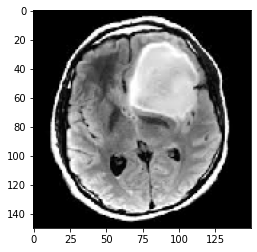

label: 1.0
antes do aumento de mais uma dimensão: (150, 150, 3)
depois do aumento de mais uma dimensão: (1, 150, 150, 3)
previsão: [[0.999818]]
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Classe prevista: [[1]]


In [34]:
def visualize_previsao(x_test, y_test, img_a_mostrar):
    print("X_test:",x_test.shape)
    print("y_test:",y_test.shape)
    print("Imagem:",x_test[img_a_mostrar].shape)
    plt.imshow(x_test[img_a_mostrar,:,:,0], cmap='gray')
    plt.show()
    print("label:",y_test[img_a_mostrar])
    print("antes do aumento de mais uma dimensão:",x_test[img_a_mostrar].shape)
    imagem_tensor = np.expand_dims(x_test[img_a_mostrar], axis=0)
    print("depois do aumento de mais uma dimensão:",imagem_tensor.shape)
    print("previsão:",model.predict(imagem_tensor))
    classes = model.predict_classes(imagem_tensor)
    print('Classe prevista:',classes)
    return imagem_tensor

imagem_tensor = visualize_previsao(dados_teste.__getitem__(0)[0], dados_teste.__getitem__(0)[1], 0)

(None, 148, 148, 60)
(None, 74, 74, 60)
(None, 74, 74, 60)
(1, 148, 148, 60)


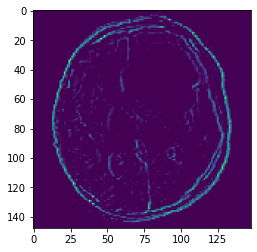

In [39]:
camadas_outputs = []
for layer in model.layers[:3]:
    print(layer.output.shape)
    camadas_outputs.append(layer.output)

# e depois criamos um modelo que retorna estes outputs dado os inputs do modelo
activation_model = models.Model(inputs=model.input, outputs=camadas_outputs) 
activations = activation_model.predict(imagem_tensor) 
first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.imshow(first_layer_activation[0, :, :, 9], cmap='viridis')
plt.show()

nome_camada: conv2d_1
n_features: 60
size: 148
n_linhas: 4
nome_camada: max_pooling2d_1
n_features: 60
size: 74
n_linhas: 4
nome_camada: dropout_1
n_features: 60
size: 74
n_linhas: 4


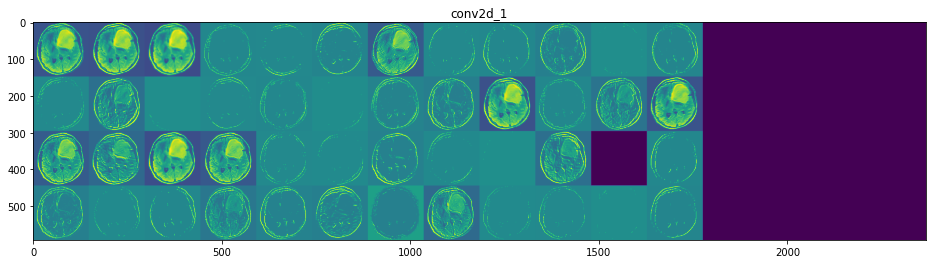

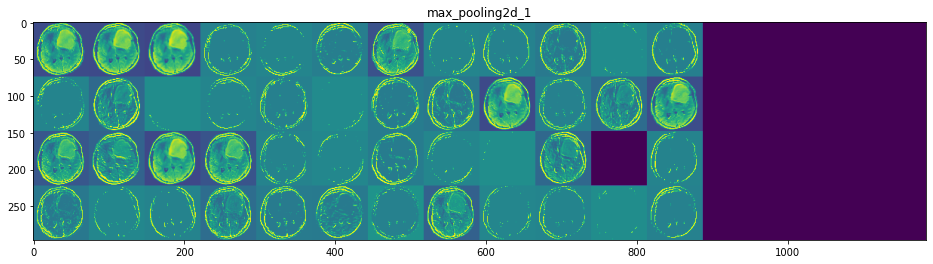

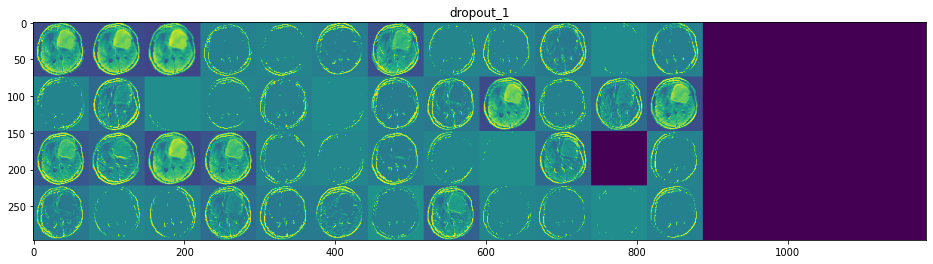

In [51]:
nomes_camadas = []
for camada in model.layers[:12]:
    nomes_camadas.append(camada.name) # para puder colocar o nome da cada camada nas visualizações

imagens_por_linha = 16

for nome_camada, ativacao_camada in zip(nomes_camadas, activations): # o zip permite iterar simultaneamente em 2 listas
    n_features = ativacao_camada.shape[-1] # Numero de features no feature map, pois é o que está na ultima dimensão
    size = ativacao_camada.shape[1] #O feature map tem shape (1, tamanho, tamanho, numero_features).
    n_linhas = -(-n_features // imagens_por_linha) # Empilha os canais de ativação nesta matriz
    print("nome_camada:",nome_camada)
    print("n_features:",n_features)
    print("size:",size)
    print("n_linhas:",n_linhas)
    display_grid = np.zeros((size * n_linhas, imagens_por_linha * size))
    for col in range(n_linhas): # para fazer o display com 15 imagens por linha
        for lin in range(imagens_por_linha -4):
            #verificar aqui se a imagem existe
            imagem = ativacao_camada[0,:,:,col * imagens_por_linha + lin] #isto pode dar erro de out-of-range
            imagem -= imagem.mean() # pos-processamento para melhor visualização
            imagem /= imagem.std()
            imagem *= 64
            imagem += 128
            imagem = np.clip(imagem, 0, 255).astype('uint8') #valores <0 ficam 0 e >255 ficam = 255
            display_grid[col * size : (col + 1) * size,lin * size : (lin + 1) * size] = imagem
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(nome_camada)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis') 